In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB4
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [4]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150

In [5]:
for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Data/MRI Images/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('/content/drive/MyDrive/Data/MRI Images/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 74/74 [00:15<00:00,  4.75it/s]


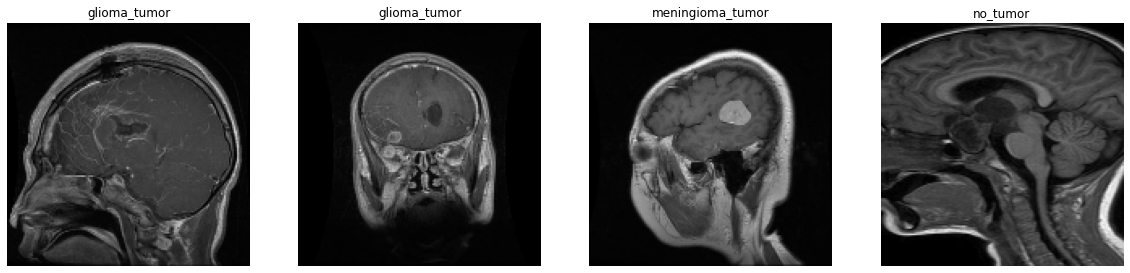

In [6]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
k = 0
for i in range(0,4):
    if i==0: idx=0
    elif i==1: idx=827
    elif i==2: idx=1649
    else: idx=2045
    ax[k].imshow(X_train[idx])
    ax[k].set_title(Y_train[idx])
    ax[k].axis('off')
    k+=1

In [7]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=28)

In [8]:
X_train.shape

(2880, 150, 150, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


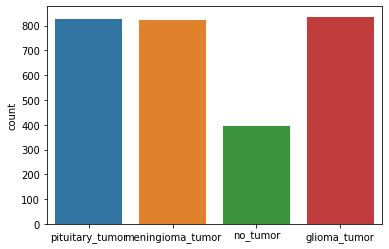

In [9]:
sns.countplot(Y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


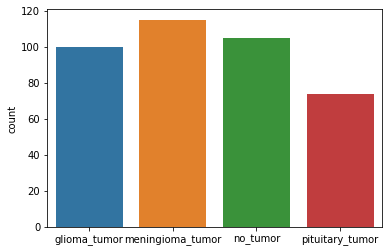

In [10]:
sns.countplot(Y_test)

In [11]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=28)

In [13]:
base_model = EfficientNetB4(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

In [14]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain_tumor_classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [17]:
datagen = ImageDataGenerator(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=10,
zoom_range=0.2,
width_shift_range=0.2,
horizontal_flip=False,
vertical_flip=False)

datagen.fit(X_train)

In [18]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              validation_data=(X_val, Y_val), 
                              epochs=50, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 1.4004 - accuracy: 0.3711
Epoch 1: val_accuracy improved from -inf to 0.30208, saving model to brain_tumor_classification.h5
72/72 [==============================] - 65s 474ms/step - loss: 1.4004 - accuracy: 0.3711 - val_loss: 1.3892 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 1.2266 - accuracy: 0.4332
Epoch 2: val_accuracy did not improve from 0.30208
72/72 [==============================] - 30s 415ms/step - loss: 1.2266 - accuracy: 0.4332 - val_loss: 1.5674 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 1.1123 - accuracy: 0.5213
Epoch 3: val_accuracy did not improve from 0.30208

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
72/72 [==============================] - 29s 405ms/step - loss: 1.1123 - accuracy: 0.5213 - val_loss: 1.5349 - val_accuracy: 0.3021 - lr: 0.0010
Epoch

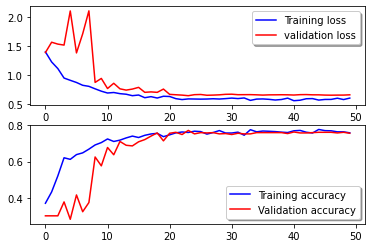

In [19]:
# Visualise the performance of the trained model & Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
# Evaluate the model 

pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

In [21]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 39.59%


In [22]:
print(classification_report(y_test_new,pred,target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.68      0.13      0.22       100
meningioma_tumor       0.45      0.35      0.39       115
        no_tumor       0.31      0.66      0.42       105
 pituitary_tumor       0.56      0.46      0.50        74

        accuracy                           0.40       394
       macro avg       0.50      0.40      0.38       394
    weighted avg       0.49      0.40      0.38       394

